In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras.utils import print_summary, to_categorical, np_utils

Using TensorFlow backend.


In [2]:
#In this case the images are in a excel sheet with a pixel of value 1 or 0
trainImages = pd.read_csv("train.csv", delimiter=',')
testImages = pd.read_csv("test.csv", delimiter=',')

The images we are 28*28 pixels giving us 784 columns and the last column labels is what number they are

In [3]:
trainImages.shape

(42000, 785)

In [4]:
#split the images and labels into x and y respectively 
trainImagesX = trainImages.drop(['label'], axis=1)
trainImagesY = trainImages['label']

## Split the data

Creating a validation set with a small portion of the data

In [5]:
newTrainImagesX, validationImagesX, newTrainLabelsY, validationLabelsY = train_test_split(trainImagesX, trainImagesY, train_size = 0.9, test_size = 0.1, random_state = 0)

## Normalize

The most common pixel format is the byte image, where this number is stored as an 8-bit integer giving a range of possible values from 0 to 255. Typically zero is taken to be black, and 255 is taken to be white. Values in between make up the different shades of gray.
We perform a greyscale normlization to reduce the effect of illumination's differences, Moreover the CNN converge faster on [0..1] data than on [0..255]

In [6]:
newTrainImagesX = (newTrainImagesX/255.0)
validationImagesX = (validationImagesX/255.0)
testImages = (testImages/255.0)

## Reshape

Train and test images (28px * 28px) has been stock into pandas.Dataframe as 1D vectors of 784 values. We reshape all data to 28x28x1 3D matrices.

Keras requires an extra dimension in the end which correspond to channels. MNIST images are gray scaled so it use only one channel. For RGB images, there is 3 channels, we would have reshaped 784px vectors to 28x28x3 3D matrices.

In [7]:
#Reshape image in 3 dimensions (height = 28px, width = 28px , canal = 1)
newTrainImagesX = newTrainImagesX.values.reshape(-1,28,28,1)
validationImagesX = validationImagesX.values.reshape(-1,28,28,1)
testImages = testImages.values.reshape(-1,28,28,1)

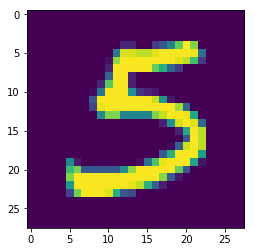

In [8]:
# Some examples
g = plt.imshow(newTrainImagesX[10][:,:,0])

## Label Encoding

In [9]:
# Encode labels to one hot vectors (ex : 2 -> [0,0,1,0,0,0,0,0,0,0])
newTrainLabelsY = to_categorical(newTrainLabelsY, num_classes = 10)
validationLabelsY = to_categorical(validationLabelsY, num_classes = 10)

## CNN

I used the Keras Sequential API, where you have just to add one layer at a time, starting from the input.

The first is the convolutional (Conv2D) layer. The purpose of convolution is to extract features from the input image. Convolution preserves the spatial relationship between pixels by learning image features using small squares of input data.
Stride is the number of pixels by which we slide our filter matrix over the input.
kernel_size, an integer or tuple/list of 2 integers, specifying the height and width of the 2D convolution window.
The CNN can isolate features that are useful everywhere from these transformed images (feature maps).

ReLU stands for Rectified Linear Unit and is a non-linear operation. ReLU is an element wise operation (applied per pixel) and replaces all negative pixel values in the feature map by zero. The purpose of ReLU is to introduce non-linearity in our ConvNet, since most of the real-world data we would want our ConvNet to learn would be non-linear (note that convolution is a linear operation – element wise matrix multiplication and addition). 

Spatial Pooling (also called subsampling or downsampling) reduces the dimensionality of each feature map but retains the most important information. Spatial Pooling can be of different types: Max, Average, Sum etc.

The Flatten layer is use to convert the final feature maps into a one single 1D vector. This flattening step is needed so that you can make use of fully connected layers after some convolutional/maxpool layers. It combines all the found local features of the previous convolutional layers.

The CNN made here is the AlexNet which won the 2012 ImageNet 2012 competition by a larger margin, 15.3%(first) vs 26.2%(second) error rate.

In [10]:
numClasses = newTrainLabelsY.shape[1]

In [11]:
model = Sequential()
#Convolutional input layer, 28 feature maps with a size 2x2, a rectifier activation function
model.add(Conv2D(48, (3,3), strides = (2,2), input_shape=(28,28,1), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2,2)))
# Local Response normalization for Original Alexnet
model.add(BatchNormalization())

model.add(Conv2D(96, (3,3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(3, 3), strides=(2,2)))
# Local Response normalization for Original Alexnet
model.add(BatchNormalization())

model.add(Conv2D(192, (3,3), activation='relu', padding='same'))
model.add(Conv2D(192, (3,3), activation='relu', padding='same'))
model.add(Conv2D(256, (3,3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(3, 3), strides=(2,2)))
# Local Response normalization for Original Alexnet
model.add(BatchNormalization())

model.add(Flatten())
model.add(Dense(512, activation='tanh'))
model.add(Dropout(0.5))
model.add(Dense(256, activation='tanh'))
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))

In [12]:
model.compile(loss='categorical_crossentropy', optimizer='Adam',metrics=['accuracy'])

In [13]:
history = model.fit(newTrainImagesX, newTrainLabelsY, epochs=50, validation_split=0.2, shuffle=True)

Train on 30240 samples, validate on 7560 samples
Epoch 1/50
30240/30240 [==============================] - 44s 1ms/step - loss: 0.2375 - acc: 0.9279 - val_loss: 0.1507 - val_acc: 0.9582
Epoch 2/50
30240/30240 [==============================] - 43s 1ms/step - loss: 0.1071 - acc: 0.9705 - val_loss: 0.1030 - val_acc: 0.9694
Epoch 3/50
30240/30240 [==============================] - 43s 1ms/step - loss: 0.0750 - acc: 0.9797 - val_loss: 0.1130 - val_acc: 0.9735
Epoch 4/50
30240/30240 [==============================] - 43s 1ms/step - loss: 0.0645 - acc: 0.9814 - val_loss: 0.0916 - val_acc: 0.9759
Epoch 5/50
30240/30240 [==============================] - 43s 1ms/step - loss: 0.0571 - acc: 0.9837 - val_loss: 0.0870 - val_acc: 0.9770
Epoch 6/50
30240/30240 [==============================] - 43s 1ms/step - loss: 0.0476 - acc: 0.9865 - val_loss: 0.0773 - val_acc: 0.9816
Epoch 7/50
30240/30240 [==============================] - 43s 1ms/step - loss: 0.0472 - acc: 0.9874 - val_loss: 0.0928 - val_acc:

In [19]:
#now to get more insight, the training-validation accuracy and error graph can be visualized
trainAcc = history.history['acc']
validAcc = history.history['val_acc']
trainErr = history.history['loss']
validErr = history.history['val_loss']

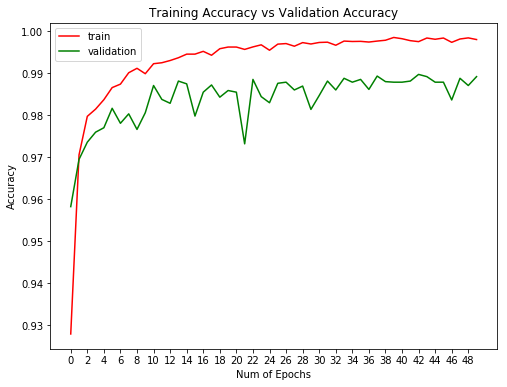

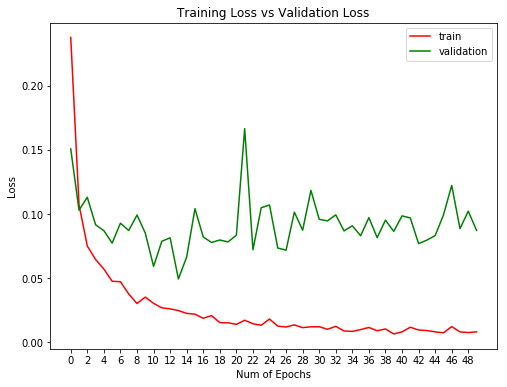

In [20]:
#plot the figures
plt.figure(0)
plt.plot(trainAcc,'r')
plt.plot(validAcc,'g')
plt.xticks(np.arange(0, len(trainAcc),2.0))
plt.rcParams['figure.figsize']=(8,6)
plt.xlabel("Num of Epochs")
plt.ylabel("Accuracy")
plt.title("Training Accuracy vs Validation Accuracy")
plt.legend(['train','validation']) 

plt.figure(1)
plt.plot(trainErr,'r') 
plt.plot(validErr,'g') 
plt.xticks(np.arange(0, len(trainAcc), 2.0)) 
plt.rcParams['figure.figsize'] = (8, 6) 
plt.xlabel("Num of Epochs") 
plt.ylabel("Loss") 
plt.title("Training Loss vs Validation Loss")
plt.legend(['train','validation']) 
plt.show()

In [16]:
y_hat = model.predict(validationImagesX)
y_pred = np.argmax(y_hat, axis=1)
y_true = np.argmax(validationLabelsY, axis=1)
cm = confusion_matrix(y_true, y_pred)
print(cm)

[[416   0   0   1   0   0   2   2   1   0]
 [  0 471   1   0   0   0   0   0   1   0]
 [  1   0 404   1   0   0   0   1   1   1]
 [  0   0   2 419   0   3   0   1   1   0]
 [  0   1   0   0 425   0   1   0   0   2]
 [  0   0   0   0   0 380   2   0   0   0]
 [  0   1   0   0   0   0 411   0   0   0]
 [  0   2   5   1   0   0   0 460   0   1]
 [  0   2   0   1   0   1   2   0 378   0]
 [  1   1   0   2   3   0   0   0   1 386]]


In [17]:
#predict the results given the test images
results = model.predict(testImages)

In [18]:
#creating the csv
results = np.argmax(results, axis=1)
results = pd.Series(results,name="Label")

submission = pd.concat([pd.Series(range(1,28001),name = "ImageId"),results],axis = 1)
submission.to_csv("digitRecog2.csv",index=False)